In [1]:
import time
import os

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

import cancernet
from cancernet.arch import PNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [3]:
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [4]:
maps[0].sum(axis=0).sort_values(ascending=False).head(20)

R-HSA-597592     797.0
R-HSA-73857      731.0
R-HSA-372790     524.0
R-HSA-168249     516.0
R-HSA-1280218    383.0
R-HSA-199991     382.0
R-HSA-556833     366.0
R-HSA-1280215    339.0
R-HSA-422475     285.0
R-HSA-9006934    268.0
R-HSA-5663202    245.0
R-HSA-194315     218.0
R-HSA-5663205    206.0
R-HSA-2262752    186.0
R-HSA-9006925    180.0
R-HSA-5683057    168.0
R-HSA-71291      165.0
R-HSA-195721     165.0
R-HSA-72203      163.0
R-HSA-71387      161.0
dtype: float64

In [5]:
# use only top subsys
#n_top = 12
#maps[0] = maps[0][maps[0].sum(axis=0).sort_values(ascending=False).head(n_top).index]
maps[0].head()

,R-HSA-196854,R-HSA-174824,R-HSA-8935690,R-HSA-391251,R-HSA-1632852,R-HSA-428359,R-HSA-8863678,R-HSA-73864,R-HSA-1368082,R-HSA-597592,...,R-HSA-186712,R-HSA-3781865,R-HSA-112315,R-HSA-9006934,R-HSA-211859,R-HSA-8981607,R-HSA-381426,R-HSA-8963676,R-HSA-3000157,R-HSA-5668914
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AADACL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
maps[0].shape

(9054, 146)

In [7]:
maps[0].sum(axis=0).sort_values(ascending=False)

R-HSA-597592     797.0
R-HSA-73857      731.0
R-HSA-372790     524.0
R-HSA-168249     516.0
R-HSA-1280218    383.0
                 ...  
R-HSA-8963676      2.0
R-HSA-5676934      2.0
R-HSA-1566977      1.0
R-HSA-8981607      1.0
R-HSA-71737        1.0
Length: 146, dtype: float64

## Train

Set up hyperparameters and random seed.

In [8]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 500
batch_size = 10
lr = 0.01

Global seed set to 42


Prepare data.

In [9]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Create and train model.

In [10]:

t0 = time.time()
model = PNet(
    layers=maps,
    num_genes=maps[0].shape[0], # 9054
    num_features=3,
)
logger = InMemoryLogger()
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=100, verbose=False, mode="min"
)
checkpoint_callback = ModelCheckpoint(
    dirpath="model_ckpts",
    monitor="val_loss",
    save_top_k=1,
    filename="bestmodel_pnet",
    mode="min",
)
bestmodel_file = os.path.join("model_ckpts", "bestmodel_pnet.ckpt")
if os.path.isfile(bestmodel_file):
    os.remove(bestmodel_file)

# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar(), early_stop_callback, checkpoint_callback],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/zzhang/anaconda3/envs/cancernet/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /mnt/ceph/users/zzhang/cancer-net/demos/model_ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | ModuleList | 47.5 K
---------------------------------------
47.5 K    Trainable params
0         Non-trainable params
47.5 K    Total params
0.190     Total estimated model params size (MB)
/mnt/home/zzhang/anaconda3/envs/cancernet/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may b

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training took 307.6 seconds.


Visualize training trajectory.

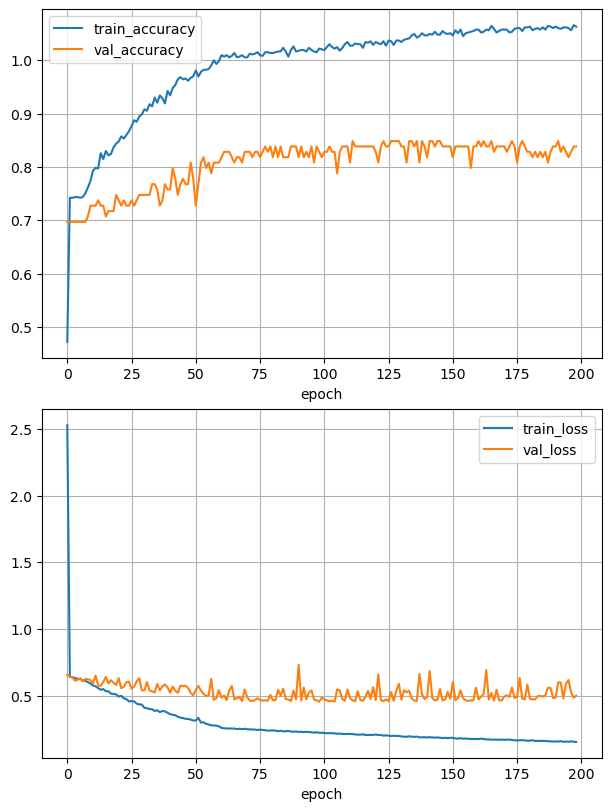

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

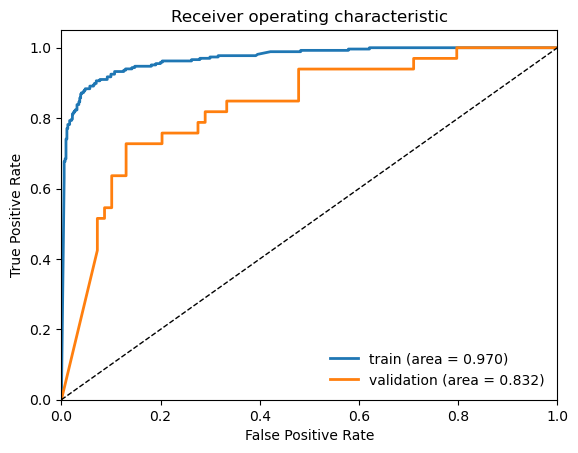

In [12]:
bestmodel_file = os.path.join("model_ckpts", "bestmodel_pnet.ckpt")
model = PNet.load_from_checkpoint(bestmodel_file)

fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [13]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.79
auc 0.8349163274536409
aupr 0.7046869083644448
f1 0.6666666666666666
precision 0.7
recall 0.6363636363636364


In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Oct 01 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pytorch_lightning: 1.6.5
cancernet        : 0.0.5
torch            : 1.11.0
torch_geometric  : 2.0.4
matplotlib       : 3.5.3

Watermark: 2.3.1

